# **Text Mining Project - Group 8** 

|      |     Student Name     |     Student ID     |
|---   |         ---          |           ---          |
| 1    |      Mariana Cabral    |       20230532       |
| 2    |      Sofia Pereira       |       20230568	       |
|3| Susana Pires |20230540 |

## Goal: 
**Implement an NLP Classification model able to predict, for each property, if it was unlisted (1) in the next quarter or is still listed (0)**


Docs for organization: <br>
https://docs.google.com/document/d/1cU9rkjof2L1qmxQwBYIpzOMezUiTN0xATmCpiLne1_c/edit?usp=sharing

Link for report: <br>
https://liveeduisegiunl-my.sharepoint.com/:w:/g/personal/20230568_novaims_unl_pt/Ee5Xaa2zAJtOj_6C7T8apkgB3_gYWxfbe4SQxlCq9Ld0PA?e=YFEFAF

## **TO DO:**
- Check small text (does it have any meaning?);
- Treat Emojis;
- If we have languages we can calculate stopwords and all for all of them;
- Test different models for each feature engineering method (and with and without undersampling/oversapling).

We can do hold-out method.\
Sets in comments.

## **1. Import Libraries &  Documents:**

### Libraries:

In [1]:
# % installs on environment  // ! installs on base
# https://stackoverflow.com/questions/65547021/difference-between-pip-and-pip-in-python-jupyter-notebook-and-colab

# !pip install bs4
# !pip install nltk
# !pip install langdetect
# !pip install lxml

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud 

# Preprocessing and Feature Extraction
from bs4 import BeautifulSoup #remove html tags
from langdetect import detect, LangDetectException

# NLTK
import os
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import re
from tqdm import tqdm

# SKLEARN
from sklearn.model_selection import train_test_split


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Import Datasets:

In [3]:
train = pd.read_excel('Project Corpora/train.xlsx')
train_reviews = pd.read_excel('Project Corpora/train_reviews.xlsx')
test= pd.read_excel('Project Corpora/test.xlsx')
test_reviews = pd.read_excel('Project Corpora/test_reviews.xlsx')

In [4]:
train.head()

,index,description,host_about,unlisted
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0


In [5]:
train_reviews.head()

,index,comments
0,1,this is a very cozy and comfortable house to s...
1,1,good<br/>
2,1,"My first hostel experience, and all I have to ..."
3,1,Das Hostel war neu und deshalb funktionierte a...
4,1,"It was fine for a dorm, but I think for the pe..."


In [6]:
test.head()

,index,description,host_about
0,1,<b>The space</b><br />Apartment located in the...,"Gosto de viajar, de conhecer pessoas, gosto de..."
1,2,"IMPORTANT: In response to COVID-19, this prope...",We are the be@home Team!\n\nYou can count on u...
2,3,"Bright, beautiful, and spacious. This four-bed...","Hi there!\n\nWe're GuestReady, a professional ..."
3,4,Charming Apartment Close to the Bay of Cascais...,:)
4,5,"Se procura umas férias perto da praia, casino ...",Bem vindos a Portugal!_x000D_\nAdoro o meu Paí...


In [7]:
test_reviews.head()

,index,comments
0,1,Thank you very much Antonio ! All has been per...
1,1,Very nice appartment in the old town of Lissab...
2,1,When travelling we're looking for kids friendl...
3,1,We've been in Lisbon in march 2013 (3 adults a...
4,1,Our host Antonio was very helpful with informa...


### Documents (Copies of the Datasets):

The **Corpora** is composed by the following documents:

•  _`airbnb_df_train `_(train) (6,248 lines): Contains the Airbnb and host descriptions
(“description” and “host_about” columns), as well as the information regarding the
property listing status (“unlisted” column). A property is considered unlisted (1) if
it got removed from the quarterly Airbnb list and it is considered listed (0) if it
remains on that same list.

• _`airbnb_df_train_reviews`_ (train_reviews) (361,281 lines): This file has all the guests’
comments made to each Airbnb property. Note that there can be more than one
comment per property, not all properties have comments, and comments can
appear in many languages.

• _`airbnb_df_test`_ (test) (695 lines): The structure of this dataset is the same as the train set, except that it does not contain the “unlisted” column.

• _`airbnb_df_test_reviews `_ (test_reviews) (41,866 lines): same srtucter as the train reviews set, but the comments correspond to the properties
present on the test set.

**Important notes** about the relation between  _`airbnb_df_train `_ &  _`airbnb_df_train_reviews`_:
- There can be more than one comment per listing;
- Not all properties have comments;
- Comments can appear in many languages;

In [8]:
airbnb_df_train = train.copy()
airbnb_df_train_reviews = train_reviews.copy()
airbnb_df_test= test.copy()
airbnb_df_test_reviews = test_reviews.copy()

----

## **2. Data Exploration**

<div class="alert alert-block alert-success"> <a id = "preprocessing"></a>

**Requirements**
- Analyze the corpora;  (DONE)
- Provide Conclusions; (DONE)
- Provide Visual Information (bar chart, word cloud…) with context;

There are no extra points.

Reference: 
- https://www.kaggle.com/code/harshsingh2209/complete-guide-to-eda-on-text-data
- https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/
- https://spotintelligence.com/2023/09/15/exploratory-data-analysis-nlp/

###  **2.1 Documents General Analysis:**

####  **2.1.1 airbnb_df_train & airbnb_df_test**

We start by checking if the indexes in *airbnb_df_train* are unique:

In [9]:
airbnb_df_train['index'].nunique()

6248

Since 6248 is equal to the number of total lines, there are no duplicated indexes and so the column "index"  can be turned into the index of the dataframe corresponding to the "ID" of a certain house:

In [10]:
airbnb_df_train.set_index('index', inplace = True)
airbnb_df_train.head()

,description,host_about,unlisted
index,,,
1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0
2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1
3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1
4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0
5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0


Let's do the same verification for *airbnb_df_test*:

In [11]:
airbnb_df_test['index'].nunique()

695

We came to the same conclusion, so the same thing is done for the test set:

In [12]:
airbnb_df_test.set_index('index', inplace = True)
airbnb_df_test.head()

,description,host_about
index,,
1,<b>The space</b><br />Apartment located in the...,"Gosto de viajar, de conhecer pessoas, gosto de..."
2,"IMPORTANT: In response to COVID-19, this prope...",We are the be@home Team!\n\nYou can count on u...
3,"Bright, beautiful, and spacious. This four-bed...","Hi there!\n\nWe're GuestReady, a professional ..."
4,Charming Apartment Close to the Bay of Cascais...,:)
5,"Se procura umas férias perto da praia, casino ...",Bem vindos a Portugal!_x000D_\nAdoro o meu Paí...


We then check for the size of our datasets:

In [13]:
airbnb_df_train.shape, airbnb_df_test.shape

((6248, 3), (695, 2))

We have **6248** records in the train dataset and **695** on the test.

Now let's check the **duplicates**:

In [14]:
airbnb_df_train.duplicated().sum()

192

There are also **192** duplicated entries in the train set.

In [15]:
duplicated_rows = airbnb_df_train[airbnb_df_train.duplicated(keep = False)]
duplicated_rows.head()

,description,host_about,unlisted
index,,,
17,"Set in a stunning seaside location, this luxur...",Going someplace new is always exciting. And wh...,0
45,"Welcome to this well-appointed, charming and v...",I do not spare any efforts when it comes to tr...,0
58,there are 4 rooms in this apartment. this room...,我喜欢旅游健身，喜欢交朋友，我是一名企业管理者，我热爱我的工作.,0
76,Nesha Guesthouse Lisbon is a surf & beach orie...,I'm an enthusiastic and active person who love...,0
78,"Located in Chiado district, one of the trendie...",Hi! Welcome to Lisbon Five Stars apartments. \...,0


In [16]:
airbnb_df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6248 entries, 1 to 6248
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  6248 non-null   object
 1   host_about   6248 non-null   object
 2   unlisted     6248 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 195.2+ KB


As expected, the ``description`` and the ``host_about`` features are stored as strings, and the ``unlisted`` is stored as an integer. We can see that,  apparently, there are no missing values (or missing text) in any feature.

 **Assumptions:** 
- We will treat duplicated entries as different properties (as per indication of teachers).
- All our text fields have text in different languages (Portuguese, English, French...);


In [17]:
airbnb_df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 695 entries, 1 to 695
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  695 non-null    object
 1   host_about   695 non-null    object
dtypes: object(2)
memory usage: 16.3+ KB


####  **2.1.2 airbnb_df_train_review & airbnb_df_test_review**

Let´s check the shape:

In [18]:
airbnb_df_train_reviews.shape, airbnb_df_test_reviews.shape

((361281, 2), (41866, 2))

We have **361281** reviews in train and **41866** in test.

This shows that the variable `comments` contains a lot more information than other variables. 
We now need to understand if this information is revelant/coherent for the problem.

**1) Does every house has comments?**


In [19]:
# Checking the unique values of the index and counting them
unique_indices = airbnb_df_train_reviews["index"].unique()

# Checking how many unique indexes are there. With this information we can see how many properties are in this dataset.
print("Total houses that have at least a comment in reviews:", len(unique_indices))

Total houses that have at least a comment in reviews: 4245


**No** => Since the total number of houses is 6248, and the different house indexes in reviews are 4245, we confirm that there are houses that do not have comments.

**2) Are comments important for  listing?**

In [20]:
# Get the set of house indices from the reviews dataset
reviewed_houses_indices = set(airbnb_df_train_reviews['index'])

# Get the set of all house indices from the houses dataset
all_houses_indices = set(train['index'])

# Find the houses with no comments
houses_with_no_comments_indices = all_houses_indices - reviewed_houses_indices

# Filter the houses dataset for houses with no comments
houses_with_no_comments = train[train['index'].isin(houses_with_no_comments_indices)]

houses_with_no_comments['unlisted'].value_counts()

unlisted
1    1441
0     562
Name: count, dtype: int64

In [21]:
houses_with_comments= train[train['index'].isin(reviewed_houses_indices)]
houses_with_comments['unlisted'].value_counts()

unlisted
0    3978
1     267
Name: count, dtype: int64

**Yes** 
* If unlisted=0, it indicates that the house remains listed in the next quarter, with a higher number of houses having comments.

* If unlisted=1, it signifies that the house is removed from the listings in the next quarter, with a higher number of houses having no comments.

* **Idea:** Having comments is crucial in determining whether a house will be listed in the next trimester.

In [22]:
airbnb_df_train_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361281 entries, 0 to 361280
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   index     361281 non-null  int64 
 1   comments  361279 non-null  object
dtypes: int64(1), object(1)
memory usage: 5.5+ MB


There are 2 missing values (or missing text) in the feature coment.

In [23]:
airbnb_df_test_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41866 entries, 0 to 41865
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     41866 non-null  int64 
 1   comments  41866 non-null  object
dtypes: int64(1), object(1)
memory usage: 654.3+ KB


### **2.2 Feature Analysis**

####  **2.2.1 `unlisted`** (target variable)

In [24]:
airbnb_df_train['unlisted'].describe()

count    6248.000000
mean        0.273367
std         0.445724
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: unlisted, dtype: float64

In [25]:
airbnb_df_train['unlisted'].unique()

array([0, 1], dtype=int64)

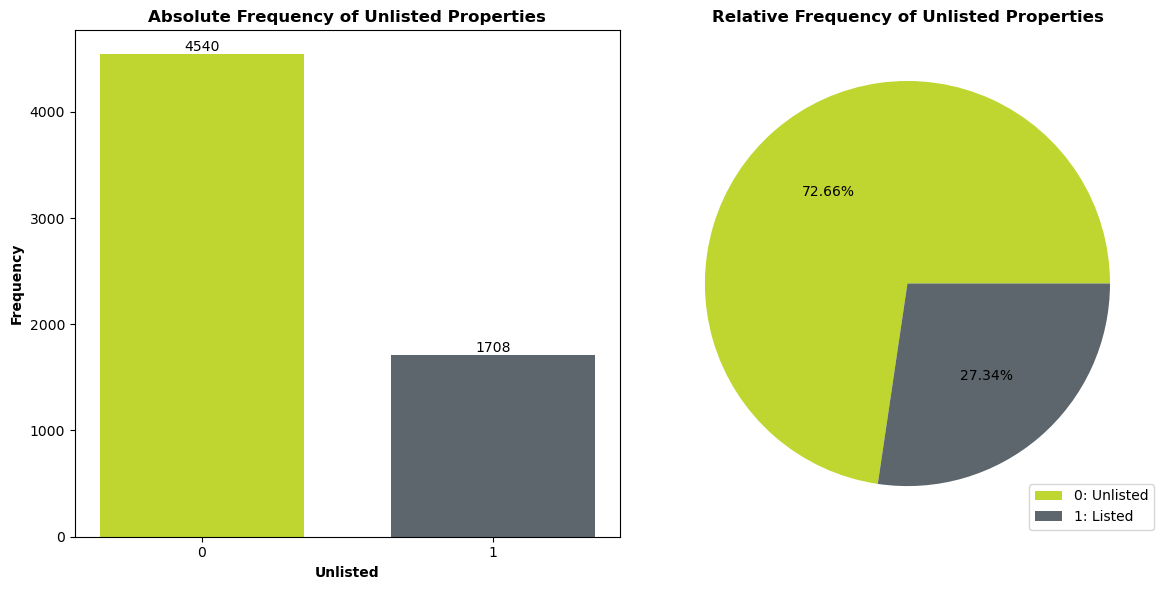

In [26]:
# Data
unlisted_counts = airbnb_df_train['unlisted'].value_counts()
total_properties = unlisted_counts.sum()
percentages = (unlisted_counts / total_properties) * 100

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Bar plot for frequency
bar_colors = ['#BED62F', '#5C666C']
bar_labels = ['0', '1']
bars = axs[0].bar(unlisted_counts.index.astype(str), unlisted_counts, color=bar_colors, width=0.7)
axs[0].grid(False)
axs[0].set_title('Absolute Frequency of Unlisted Properties', fontweight='bold')
axs[0].set_xlabel('Unlisted', fontweight='bold')
axs[0].set_ylabel('Frequency', fontweight='bold')
axs[0].tick_params(axis='x', rotation=0)
axs[0].set_xticks(unlisted_counts.index)
axs[0].set_xticklabels(bar_labels)
for p in bars:
    axs[0].annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom')

# Add legend
legend_labels = ['0: Unlisted', '1: Listed']

# Pie chart for percentages
pie_colors = ['#BED62F', '#5C666C']
wedges, texts, autotexts = axs[1].pie(percentages, autopct='%1.2f%%', colors=pie_colors)
axs[1].set_title('Relative Frequency of Unlisted Properties', fontweight='bold')

# Add legend
axs[1].legend(wedges, legend_labels, loc='lower right')

plt.tight_layout()
plt.show()


In [27]:
airbnb_df_train['unlisted'].value_counts(normalize=True)*100

unlisted
0    72.663252
1    27.336748
Name: proportion, dtype: float64

**Conclusions - Target Analysis:**
* No **mising values**  (i.e count = total number of lines)
* No **unexpected values** 
* There is a clear **unbalance**: around 73% of the training instances represent airbnb's that remain listed, while only 27% represent airbnb's that were unlisted.
    - This is an important characteristic of the data, as unbalanced data needs to be adressed so it does not affect the performance of our classification models.

#### **2.2.2 `description`**

##### **1) Overall Analysis**

In [28]:
airbnb_df_train['description'].describe()

count                                  6248
unique                                 6023
top       <b>License number</b><br />Exempt
freq                                     19
Name: description, dtype: object

In [29]:
airbnb_df_train['description'].isna().sum()

0

In [30]:
airbnb_df_train['description'].duplicated().sum()

225

**Conclusions**:
* The **most common description** is repeated 19 times, and there are 6023 unique property descriptions, so that there are **duplicated descriptions**.
* There are **no missing values**.



##### **2) Word Count** 
Turn text into words to better analyse it:
Turning our descriptions into tokens and counting how many tokens exist in each description:

In [31]:
airbnb_df_train['word_count_descr']  = airbnb_df_train['description'].apply(lambda x: len(str(x).split(" ")))
airbnb_df_train[['description','word_count_descr']].head() #number of tokens

,description,word_count_descr
index,,
1,"This is a shared mixed room in our hostel, wit...",127
2,"O meu espaço fica perto de Parque Eduardo VII,...",23
3,Trafaria’s House is a cozy and familiar villa ...,170
4,"Apartamento Charmoso no Chiado, Entre o Largo ...",47
5,Joli appartement en bordure de mer.<br /> 2 m...,101


In [32]:
airbnb_df_train.word_count_descr.describe().round(2)

count    6248.00
mean      132.86
std        48.08
min         3.00
25%        99.00
50%       157.00
75%       167.00
max       210.00
Name: word_count_descr, dtype: float64

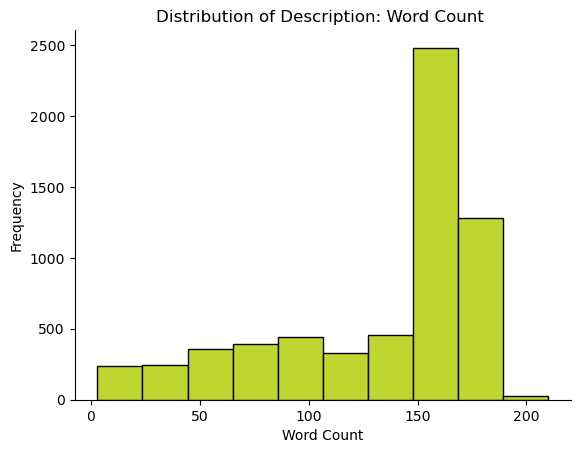

In [33]:
airbnb_df_train['word_count_descr'].hist(ec = 'black', color=['#BED62F'])
plt.grid(False)  
plt.title('Distribution of Description: Word Count ')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

**Conclusions**:
From these descriptive statistics and histogram, we can understand some interesting things about our data, such as:
- The largest description has 210 words
- The smallest description has only 3 words
- On average, descriptions have around 133 words
- The descripiton filed contains text with many different sizes, but is most commonly around [150,170] words.

##### **3) Word Analysis** 
We now analyse each word individually:

In [34]:
all_words_descr = ' '.join(airbnb_df_train['description']).split()

In [35]:
freq_descr = pd.Series(all_words_descr).value_counts() #see frequency of words

Cheking the **most common words**:

In [36]:
freq_descr.sort_values(ascending=False)[0:25]

the             31323
and             27698
a               25540
/><br           17380
to              15328
of              15122
in              13866
with            13649
is              12083
de               6918
apartment        6841
for              6153
you              6140
<br              5328
has              4863
space</b><br     4814
/><b>The         4670
from             4363
e                4288
/>The            4144
The              3426
are              3155
room             3016
located          2944
2                2937
Name: count, dtype: int64

Visualizing using a barplot:

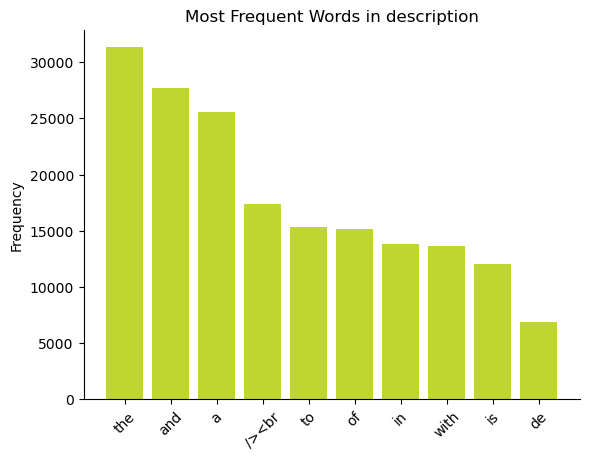

In [37]:
x_labels = freq_descr.index[0:10]
values = freq_descr[:10]
plt.bar(x_labels, values, color=['#BED62F'] )
plt.xticks(x_labels)
plt.ylabel('Frequency')
plt.title('Most Frequent Words in description')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(rotation = 45)
plt.show()

Visualizing using a word cloud:

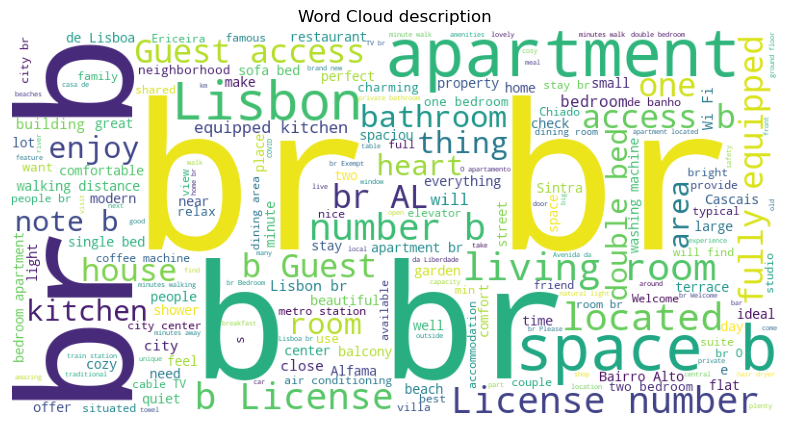

In [38]:
# Joining all the descriptions into a single string
all_reviews_descr = ' '.join(airbnb_df_train['description'])
    
# Create WordCloud object
wordcloud_descr = WordCloud(width=800, height=400, background_color="white").generate(all_reviews_descr)

#Plotting the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_descr)
plt.axis("off")
plt.title('Word Cloud description')
plt.show()

**Conclusions**:

There are clearly a lot of **uniformative words** that can be considered *stop words*, *tags* or *non-alphanumeric*, such as 'br', 'and' 'the'.\
These word should be correctly pre-processed as to not affect the outcome of our final analysis.

#### **2.2.3 `host_about`**

##### **1) Overall Analysis**

In [39]:
airbnb_df_train['host_about'].describe()

count                                                  6248
unique                                                 2803
top       We are Feels Like Home Holiday Rentals.\nA com...
freq                                                    153
Name: host_about, dtype: object

In [40]:
airbnb_df_train['host_about'].isna().sum()

0

In [41]:
airbnb_df_train['host_about'].duplicated().sum()

3445

**Conclusions**:
* There are only 2.803 **unique host_about descriptions**. This might be due to the fact that the same host might have many properties. Additionally, the **most common host_about** information is repeated 153 times.
* There are **no missing values**.

##### **2) Word Count** 
Repeat the process but this time for the variable *host_about*

In [42]:
airbnb_df_train['word_count_host']  = airbnb_df_train['host_about'].apply(lambda x: len(str(x).split(" ")))
airbnb_df_train[['host_about','word_count_host']].head() #number of tokens

,host_about,word_count_host
index,,
1,Alojamento Local Registro: 20835/AL,4
2,"I am friendly host, and I will try to always b...",24
3,"I am a social person liking to communicate, re...",45
4,Hello!_x000D_\nI m Portuguese and i love to me...,31
5,Nous sommes une famille avec deux enfants de 1...,37


In [43]:
airbnb_df_train.word_count_host.describe().round(2)

count    6248.00
mean       73.65
std        79.66
min         1.00
25%        26.00
50%        55.00
75%       101.00
max      1387.00
Name: word_count_host, dtype: float64

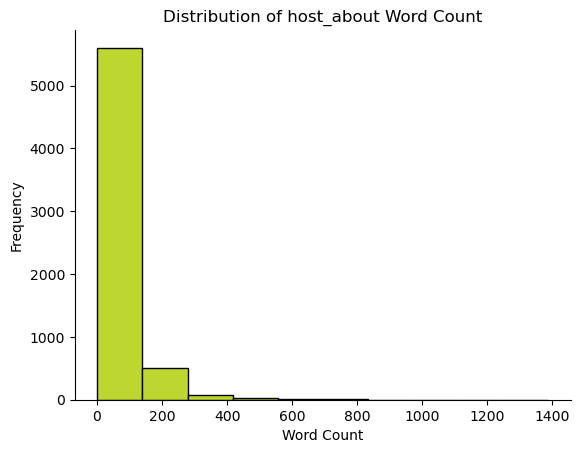

In [44]:
airbnb_df_train['word_count_host'].hist(ec = 'black', color=['#BED62F'])
plt.grid(False)  
plt.title('Distribution of host_about Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

**Conclusions**:
From these descriptive statistics and histogram, we can understand some interesting things about our data, such as:
- The largest description of the host has 1387 words
- The smallest description of the host has only 1 word
- On average, descriptions of the hosts  have around 74 words
- The *host_about* filed has generally smaller text [0,100] words, but also has extreme outliers with 10 times more words.

##### **3) Word Analysis** 
We now analyse each word individually:

In [45]:
all_words_host= ' '.join(airbnb_df_train['host_about']).split()

In [46]:
freq_host = pd.Series(all_words_host).value_counts() #see frequency of words

Cheking the most common words:

In [47]:
freq_host.sort_values(ascending=False)[0:20]

and        16358
to         13291
the        10797
a          10535
in          9860
of          6524
I           6419
you         6248
de          4325
We          4206
our         4004
e           3980
_x000D_     3971
for         3864
with        3819
is          3506
we          3481
are         2929
have        2825
my          2750
Name: count, dtype: int64

Visualizing using a barplot:

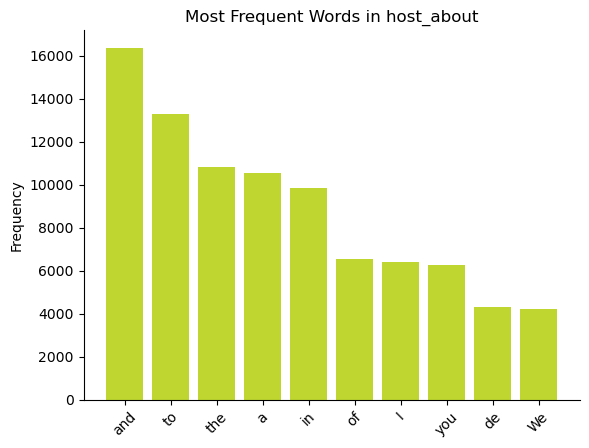

In [48]:
x_labels = freq_host.index[0:10]
values = freq_host[:10]
plt.bar(x_labels, values, color=['#BED62F'] )
plt.xticks(x_labels)
plt.ylabel('Frequency')
plt.title('Most Frequent Words in host_about')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(rotation = 45)
plt.show()

Visualizing using a word cloud:

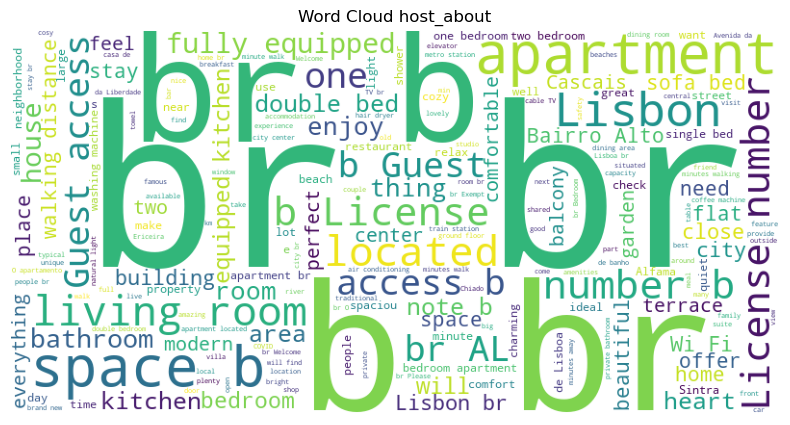

In [49]:
# Joining all the host_about into a single string
all_reviews_host = ' '.join(airbnb_df_train['host_about'])
    
# Create WordCloud object
wordcloud_descr = WordCloud(width=800, height=400, background_color="white").generate(all_reviews_descr)

#Plotting the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_descr)
plt.axis("off")
plt.title('Word Cloud host_about')
plt.show()

**Conclusions:**

There are clearly a lot of uniformative words that can be considered stop words, tags or non-alphanumeric, such as 'br', 'and' 'to'.\
These word should be correctly pre-processed as to not affect the outcome of our final analysis.

#### **2.2.4 `comments`**

##### **1) Overall Analysis**

In [50]:
airbnb_df_train_reviews['comments'].isna().sum()

2

In [51]:
rows_with_nan_comments = airbnb_df_train_reviews[airbnb_df_train_reviews['comments'].isna()]
rows_with_nan_comments

,index,comments
97996,1654,NaN
334443,5789,NaN


In [52]:
airbnb_df_train_reviews['comments'].duplicated().sum()

6781

**Conclusions:**

We have **2 missing values** and have **many duplicated values**.

##### **2) Word Count** 
Repeat the process but this time for the variable *comments*

In [53]:
airbnb_df_train_reviews['word_count_rev']  = airbnb_df_train_reviews['comments'].apply(lambda x: len(str(x).split(" ")))
airbnb_df_train_reviews[['comments','word_count_rev']].head() #number of tokens

,comments,word_count_rev
0,this is a very cozy and comfortable house to s...,28
1,good<br/>,1
2,"My first hostel experience, and all I have to ...",261
3,Das Hostel war neu und deshalb funktionierte a...,81
4,"It was fine for a dorm, but I think for the pe...",27


In [54]:
airbnb_df_train_reviews.word_count_rev.describe().round(2)

count    361281.00
mean         47.97
std          46.79
min           1.00
25%          18.00
50%          36.00
75%          63.00
max        1019.00
Name: word_count_rev, dtype: float64

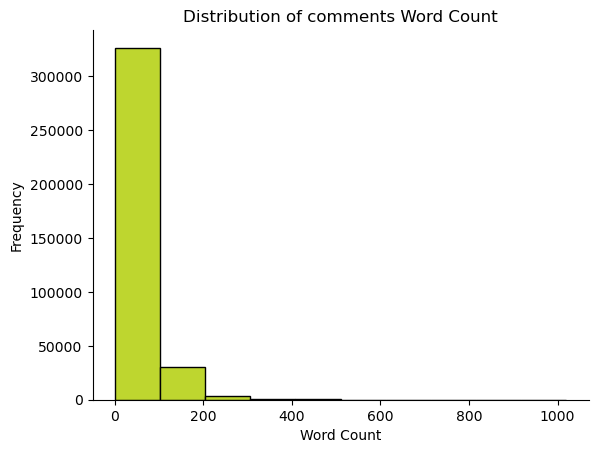

In [55]:
airbnb_df_train_reviews['word_count_rev'].hist(ec = 'black', color=['#BED62F'])
plt.grid(False)  
plt.title('Distribution of comments Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

**Conclusions**:
From these descriptive statistics and histogram, we can understand some interesting things about our data, such as:
- The largest comment has 1019 words
- The smallest comment has only 1 word
- On average, comments of the hosts  have around 48 words
- Just as with *host_about*, most *comments* have around [1,63] words but some outliers are 10 times bigger.

##### **3) Word Analysis** 
We now analyse each word individually:

In [56]:
#all_words_rev= ' '.join(airbnb_df_train_reviews['comments']).split()

The code line from above would not work as we are dealing with a variable with missing values encoded as *NaN*. This being said, we explore the problem further:

In [57]:
problematic_indices = []

for index, comment in airbnb_df_train_reviews['comments'].items():
    if isinstance(comment, float):
        problematic_indices.append(index)

problematic_rows = airbnb_df_train_reviews.loc[problematic_indices]
print(problematic_rows)

        index comments  word_count_rev
97996    1654      NaN               1
334443   5789      NaN               1


In [58]:
#The problem occurs because we have missing values, so let's no consider them (drop them)
comments_without_missing = airbnb_df_train_reviews['comments'].dropna()
all_words_rev = ' '.join(comments_without_missing).split()

In [59]:
freq_rev = pd.Series(all_words_rev).value_counts() #see frequency of words

Cheking the most common words:

In [60]:
freq_rev.sort_values(ascending=False)[0:15]

and          553157
the          515963
a            398631
to           328675
is           258191
in           249469
was          239807
of           174087
very         156654
The          143987
for          141658
de           139290
with         115782
apartment    114848
we            98283
Name: count, dtype: int64

Visualizing using a barplot:

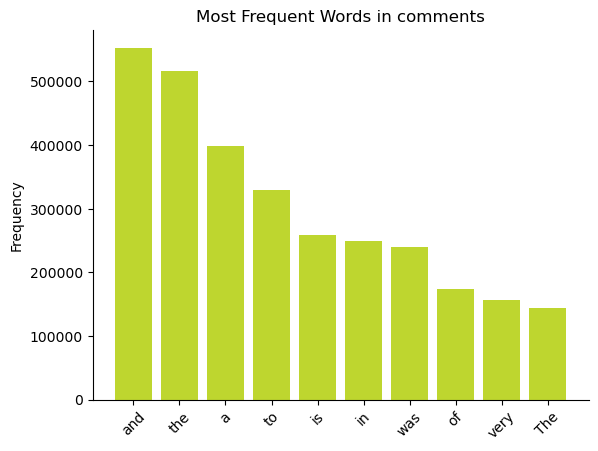

In [61]:
x_labels = freq_rev.index[0:10]
values = freq_rev[:10]
plt.bar(x_labels, values, color=['#BED62F'] )
plt.xticks(x_labels)
plt.ylabel('Frequency')
plt.title('Most Frequent Words in comments')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(rotation = 45)
plt.show()

Visualizing using a word cloud:

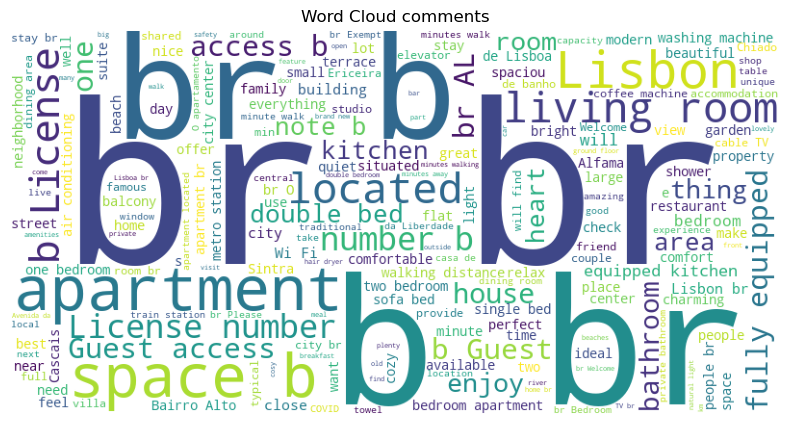

In [62]:
# Joining all the comments into a single string
all_reviews_rev = ' '.join(comments_without_missing)
    
# Create WordCloud object
wordcloud_descr = WordCloud(width=800, height=400, background_color="white").generate(all_reviews_descr)

#Plotting the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_descr)
plt.axis("off")
plt.title('Word Cloud comments')
plt.show()

**Note:**

Although we have conducted an analysis suggesting that comments may be important for unlisting, we acknowledge that sometimes comments can consist of empty strings, spaces, dots, or punctuation marks that don't provide useful information for our problem context. 
Therefore, let´s check comments with 5 or less characters and determine the number of such comments in the dataset.

In [63]:
feature = ['comments']

for entry in feature:
    #select only comments with a length less than 5 characters 
    short_values = airbnb_df_train_reviews[airbnb_df_train_reviews[entry].str.len() < 5][entry].unique()
    for comment in short_values:
        print(comment)

top
.
I
👍
Good
q
-
Top
bien
Bien
Bom.
非常满意
RAS
Bom
O
♥️
show
💚
ø
....
Na
🤙🏼
👍🏼
A
Si
...
nice
J
G
..
idem
Idem
😊
K
Ras
👌
å
Ok
Nice
Nee
****
Xxx
/
5/5
👍🏼👍🏼
:-)
L
r
🙂
!
Hi
Top!
…
🔝
Bb
👍🏻
Best
좋습니다
Nul
❤️
10
🇵🇹
x
nvt
´
!!!
NC
Ok.
E
 ...
no
😍😍😍
좋았음
🙏🏻
xxx
good
👌👌👌
ok
:)
很接地气
,
OK
N.
No
X
👍👍👍
We
D
n
非常完美
Hduj
aa
non
5*
אש
Kind
N/a
C
Gut
👍👍
좋아요
👌🏻👌🏻
S
6*!!
1
Omit
Cool
Amei
N
nada
😎😎😎😎
  . 
A+++
😉
Gh
+
Goed
Z
👌🏼👌🏼
非常好
Xx
1A
M
•
🔝🔝🔝
. 
GG
A*
👌🏾
Hh
Fab!
都很好！
挺好的
非常好👍
非常干净
_
v
cfgx
B
A a
P
五星推荐
‘
T
✌️🪨
Tks
🙏
رائع
2/5
***
Gos
5🌟
Top 
Ds
…..
✔️
👍👍👍👍
  👌🏻
😘
Ok😊
a
5⭐️
;-))
Nada
👌🏻
?
좋아요!
1 A
gut
Df
Nn
TB
🙌🏻
Veld
SN
+++👍
top!
✨
🙌🏾
0
Boa
Test
Ya
无
<3
😀
很舒适
100%
👍👌
💗
5 ⭐️
🤗
g
Grat
tnx
👌🏽
Aaaa
很好
Oui
👍🏽
☹️👎🏽
5*!
ooo
🤨
  C
Q
👌👌
还可以
Fine
Mega
Okay
**
体验不错
Thx
👍🏼👏🏼
we
i
5✨
9
Nvt
ciao
👍🏾
N/à
非常喜欢
位置不错
hu
👌🏼
👌👍
Apa
U
Todo
R
p
很干净
boa
d
--
BIEN
8.0
👍🏻🤟🏻
The 
Mhe
none
SO
cool
👏🏻
bom
好
很棒！
超赞！
9/10
Bom!
c
n/A
xx
..!
Yes!
ppp
Arnm
*
H
Yo
Guay
😉👌
The
☹️
🤟👍
🎷🦫
–
—-
Www
RAS.
: )
Boa.
yes
Very
Hyvä
5 ⭐
Fair
top.
Boa!

**Conclusions:**
There are clearly a lot of uniformative words that can be considered stop words, tags, emojis or non-alphanumeric, such as 'br', 'and' 'the'.\
 These words should be correctly pre-processed as to not affect the outcome of our final analysis.

### **2.3 Multi-Language Analysis**

As was noted earlier, our text is written in many different languages. An important step of our analysis is to understand the proportions in which each language is present in our text, as to select the best approach going forward.

There are many possible libraries that can be used to detect languages from a string. Considering the following article: https://medium.com/@monigrancharov/text-language-detection-with-python-beb49d9667b3 , using *LangDetect* is seen as the appropriate choice:

In [64]:
def detect_language_with_langdetect(text):
    """
    This function recieves as input a piece of text and return the language it corresponds to.
    It uses Langdetect as the detection algorithm.
    """
    try:
        return detect(text) # return the language with highest probability
    except: return "Unknown" # if does not recognise language

In [65]:
#Identifying the language of "description" & "host_about" in airbnb_df_train
airbnb_df_train['desc_lang'] = airbnb_df_train['description'].apply(detect_language_with_langdetect)
airbnb_df_train['ha_lang']=airbnb_df_train['host_about'].apply(detect_language_with_langdetect)

In [ ]:
airbnb_df_train[['desc_lang', 'ha_lang' ]].describe().T

,count,unique,top,freq
desc_lang,6248,12,en,5113
ha_lang,6248,30,en,4450


In [ ]:
#Identify language of "comments" in airbnb_df_train_reviews
airbnb_df_train_reviews['com_lang'] = airbnb_df_train_reviews['comments'].apply(detect_language_with_langdetect)

Saving our data into a csv so it is faster to acces it in the future:

In [ ]:
airbnb_df_train.to_csv('airbnb_df_train_lang.csv', index=False)
airbnb_df_train_reviews.to_csv('airbnb_df_train_reviews_lang.csv', index=False)

In [ ]:
airbnb_df_train_reviews['com_lang'].describe()

count     361281
unique        44
top           en
freq      232334
Name: com_lang, dtype: object

Checking our dataframes:

In [ ]:
airbnb_df_train.head()

,description,host_about,unlisted,word_count_descr,word_count_host,desc_lang,ha_lang
index,,,,,,,
1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,127,4,en,pt
2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1,23,24,pt,en
3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,170,45,en,en
4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0,47,31,pt,en
5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0,101,37,fr,fr


In [ ]:
airbnb_df_train_reviews.head()

,index,comments,word_count_rev,com_lang
0,1,this is a very cozy and comfortable house to s...,28,en
1,1,good<br/>,1,cy
2,1,"My first hostel experience, and all I have to ...",261,en
3,1,Das Hostel war neu und deshalb funktionierte a...,81,de
4,1,"It was fine for a dorm, but I think for the pe...",27,en


Having each languages identified, we further analyse these variables:

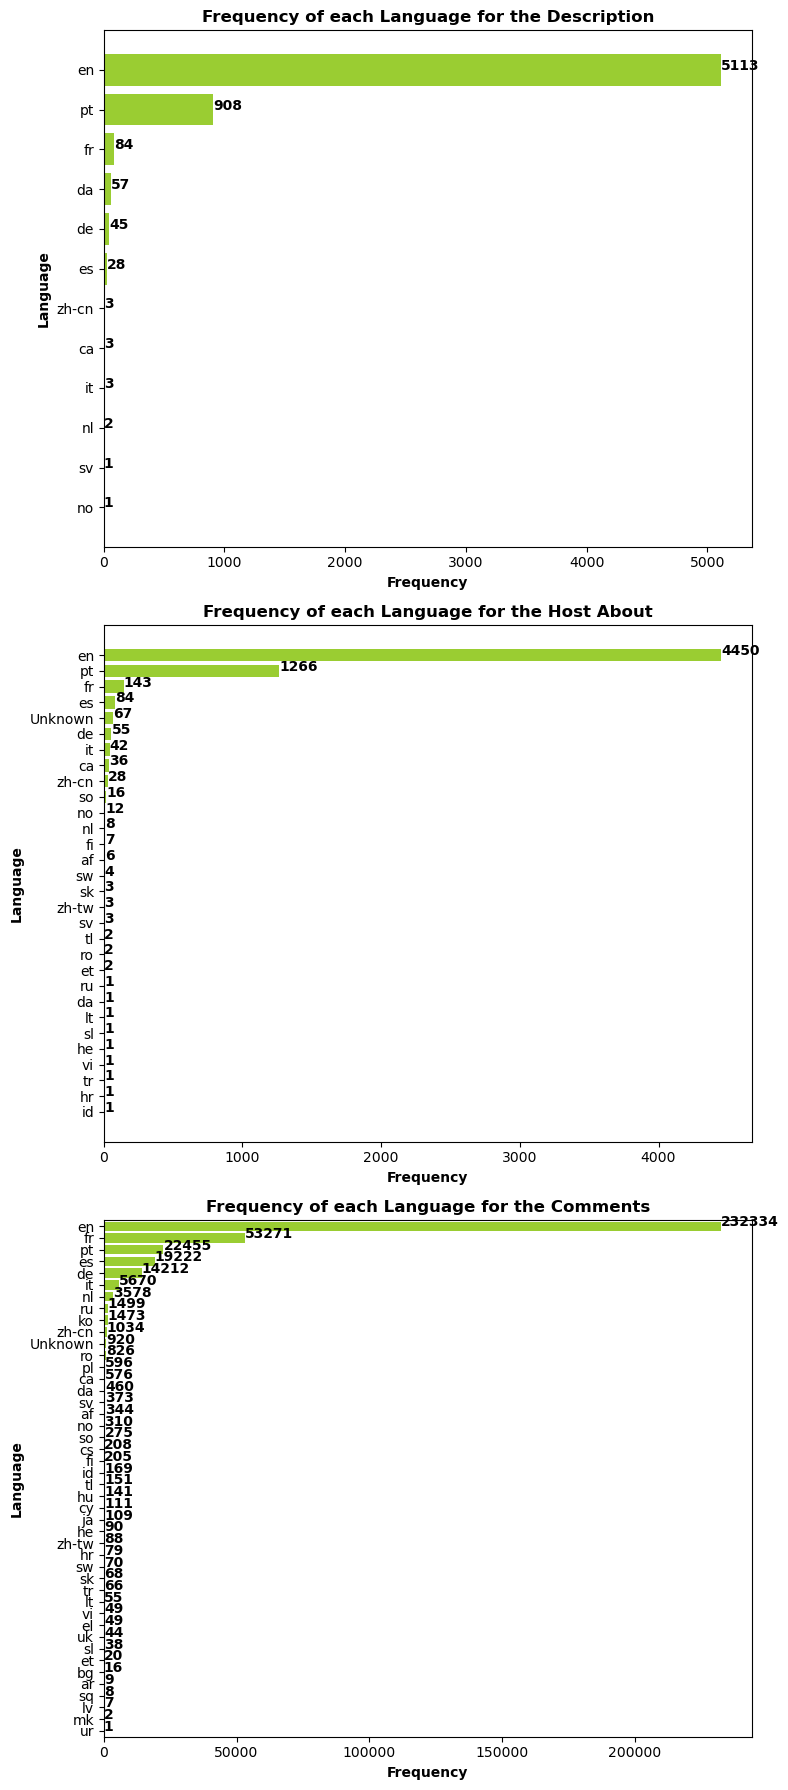

In [ ]:
# Data
desc_lang_counts = airbnb_df_train['desc_lang'].value_counts()
ha_lang_counts = airbnb_df_train['ha_lang'].value_counts()
com_lang_counts = airbnb_df_train_reviews['com_lang'].value_counts()

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(8, 18))

# Horizontal bar plot for description language
desc_lang_counts_sorted = desc_lang_counts.sort_values(ascending=True)
axs[0].barh(desc_lang_counts_sorted.index, desc_lang_counts_sorted, color='yellowgreen')
axs[0].grid(False)
axs[0].set_title('Frequency of each Language for the Description', fontweight='bold')
axs[0].set_xlabel('Frequency', fontweight='bold')
axs[0].set_ylabel('Language', fontweight='bold')

for i, v in enumerate(desc_lang_counts_sorted):
    axs[0].text(v + 0.2, i, str(v), color='black', fontweight='bold')

# Horizontal bar plot for host about language
ha_lang_counts_sorted = ha_lang_counts.sort_values(ascending=True)
axs[1].barh(ha_lang_counts_sorted.index, ha_lang_counts_sorted, color='yellowgreen')
axs[1].grid(False)
axs[1].set_title('Frequency of each Language for the Host About', fontweight='bold')
axs[1].set_xlabel('Frequency', fontweight='bold')
axs[1].set_ylabel('Language', fontweight='bold')

for i, v in enumerate(ha_lang_counts_sorted):
    axs[1].text(v + 0.2, i, str(v), color='black', fontweight='bold')

# Horizontal bar plot for comment language
com_lang_counts_sorted = com_lang_counts.sort_values(ascending=True)
axs[2].barh(com_lang_counts_sorted.index, com_lang_counts_sorted, color='yellowgreen')
axs[2].grid(False)
axs[2].set_title('Frequency of each Language for the Comments', fontweight='bold')
axs[2].set_xlabel('Frequency', fontweight='bold')
axs[2].set_ylabel('Language', fontweight='bold')

for i, v in enumerate(com_lang_counts_sorted):
    axs[2].text(v + 0.2, i, str(v), color='black', fontweight='bold')

# Adjusting vertical scale for comments language plot
axs[2].set_ylim(-0.5, len(com_lang_counts_sorted) - 0.5)

plt.tight_layout()
plt.show()


Regarding the distribution of relative frequency, we'll create pie charts. However, for better interpretation, each chart will only represent languages with a representation above 5%. All others will be included in the "Others" category.

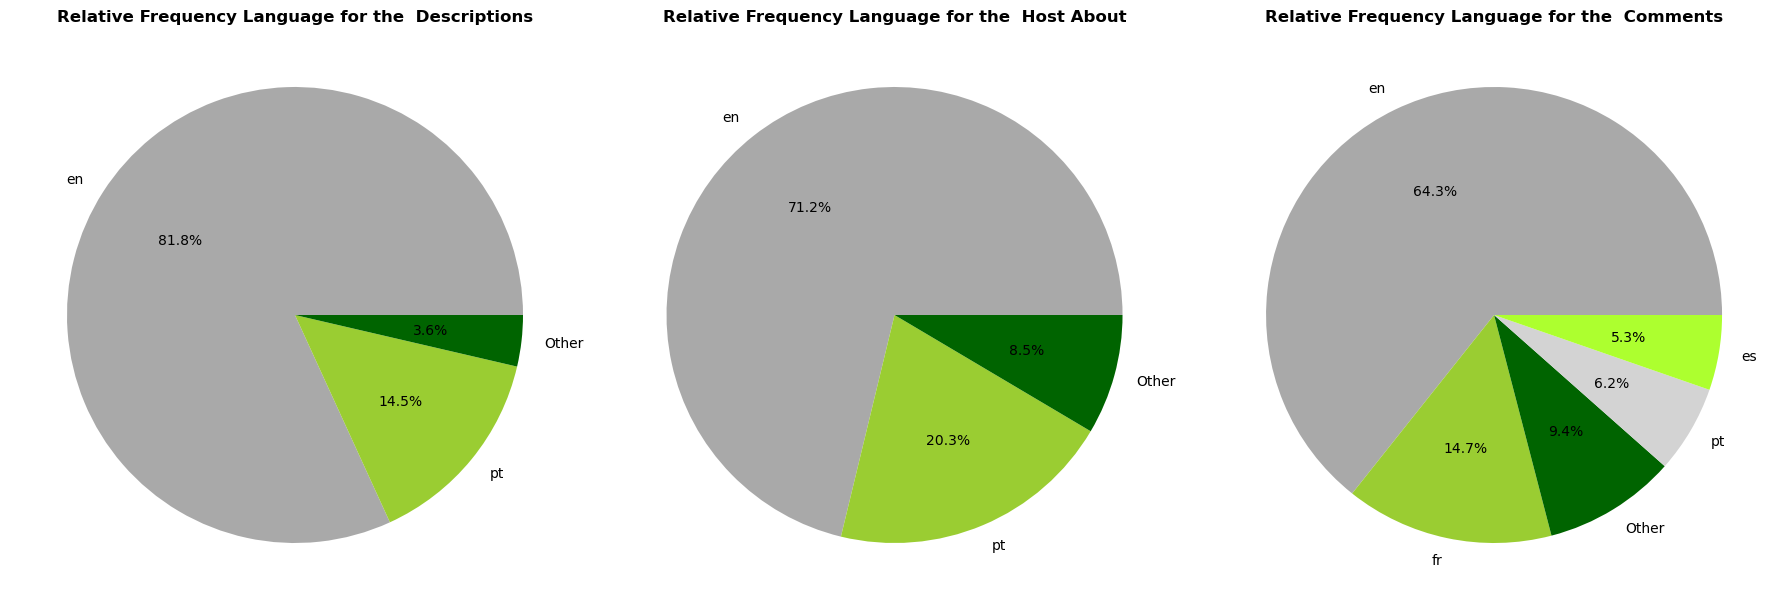

In [ ]:
# let's aggregate all the languages in less than 5% of the data for each column in one category called other

#Function to aggregate the small categories
def aggregate_categories(counts):
    total_count = counts.sum()
    filtered_counts = counts[counts / total_count * 100 > 5]
    other_count = total_count - filtered_counts.sum()
    return filtered_counts, other_count

# Counts
desc_lang_counts = airbnb_df_train['desc_lang'].value_counts()
ha_lang_counts = airbnb_df_train['ha_lang'].value_counts()
com_lang_counts = airbnb_df_train_reviews['com_lang'].value_counts()

# Aggregate small categories
desc_lang_counts_filtered, desc_lang_others = aggregate_categories(desc_lang_counts)
ha_lang_counts_filtered, ha_lang_others = aggregate_categories(ha_lang_counts)
com_lang_counts_filtered, com_lang_others = aggregate_categories(com_lang_counts)

# Create temporary columns
airbnb_df_train['desc_lang_temp'] = airbnb_df_train['desc_lang'].apply(lambda x: x if x in desc_lang_counts_filtered else 'Other')
airbnb_df_train['ha_lang_temp'] = airbnb_df_train['ha_lang'].apply(lambda x: x if x in ha_lang_counts_filtered else 'Other')
airbnb_df_train_reviews['com_lang_temp'] = airbnb_df_train_reviews['com_lang'].apply(lambda x: x if x in com_lang_counts_filtered else 'Other')



# Use the temporary columns to plot the pie charts
desc_lang_counts_temp = airbnb_df_train['desc_lang_temp'].value_counts()
ha_lang_counts_temp = airbnb_df_train['ha_lang_temp'].value_counts()
com_lang_counts_temp = airbnb_df_train_reviews['com_lang_temp'].value_counts()

# Define colors
colors = ['darkgrey','yellowgreen', 'darkgreen', 'lightgrey', 'greenyellow']

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Pie chart for description language
axs[0].pie(desc_lang_counts_temp, labels=desc_lang_counts_temp.index, autopct='%1.1f%%', colors=colors)
axs[0].set_title('Relative Frequency Language for the  Descriptions', fontweight='bold')

# Pie chart for host about language
axs[1].pie(ha_lang_counts_temp, labels=ha_lang_counts_temp.index, autopct='%1.1f%%', colors=colors)
axs[1].set_title('Relative Frequency Language for the  Host About', fontweight='bold')

# Pie chart for comment language
axs[2].pie(com_lang_counts_temp, labels=com_lang_counts_temp.index, autopct='%1.1f%%', colors=colors)
axs[2].set_title('Relative Frequency Language for the  Comments', fontweight='bold')

plt.tight_layout()
plt.show()


**Conclusion**

|                        |    Description  |     Host About    |        Comments |
|---                     |         ---     |           ---     |   ---           |
| # Distintic languages  |        12       |       30          |  44
| +/-95 %   |    en-pt        |      en-pt       |  en-fr-pt-es |


### **2.4  Checking for URL's and dates:**

Our text can include url's and dates that need to be normalized. An analysis is performed to better understand the presence of these elements in the text:

##### **URL:**

https://www.geeksforgeeks.org/python-check-url-string/

In [64]:
def Find(string):
    # with valid conditions for urls in string
    regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    url = re.findall(regex, string)
    return [x[0] for x in url]

In [65]:
def find_count_url(data):
    url = []
    for text in data:
        if Find(text)!= []:
            url.append(Find(text)),
    return len(url), url

In [66]:
print('Description has',find_count_url(airbnb_df_train['description'])[0], 'URLs.')
print('host_about has',find_count_url(airbnb_df_train['host_about'])[0], 'URLs.')
print('Comments have', find_count_url(comments_without_missing)[0], 'URLs')

Description has 23 URLs.
host_about has 37 URLs.
Comments have 51 URLs


Example of present Url:

In [67]:
find_count_url(comments_without_missing)[1]

[['https://packathon.in'],
 ['https://abnb.me/aIxlMuJU9ib'],
 ['http://www.tripadvisor.com/Restaurant_Review-g3874225-d6957429-Reviews-Manteigaria-Lisbon_District_Central_Portugal.html'],
 ['www.Turisma.pt'],
 ['https://www.aartedaterra.pt/en/'],
 ['www.travelhotspots.nl'],
 ['http://lisboaautentica.com/fr/'],
 ['https://de.wikipedia.org/wiki/Mouraria'],
 ['http://www.figaroslisboa.com'],
 ['https://www.yelp.com/biz/time-out-market-lisboa'],
 ['www.gosoohi.com'],
 ['https://www.airbnb.com/rooms/6353661'],
 ['https://www.youtube.com/watch?v=SzHHsbJ_LyM'],
 ['https://www.mafrense.pt/FileGet.aspx?FileId=6610'],
 ['https://www.youtube.com/channel/UCe5Kl8UQH0OXC9KuJ9PzkLw?view_as=subscriber'],
 ['http://www.hamburgueriadobairro.pt'],
 ['https://www.facebook.com/CurtindoPortugal/'],
 ['https://www.visitportugal.com/en/content/festas-de-lisboa'],
 ['http://www.conserveiradelisboa.pt/en'],
 ['www.facebook.com/avelhagaiteira'],
 ['https://goo.gl/maps/x3abCKBrnDR2'],
 ['www.portugalicious.pt'],


There is a clear presence of url's in our data that needs to de dealt with accordingly.

##### **Dates:**

Finding dates can be a more complex approach, since dates can come in many formats. Nevertheless, in a first approach, a simple function is created to find dates with the typical yyyy-mm-dd or dd-mm-yyyy format.

In [68]:
def find_dates(data):
    date_patterns = [
        r'\d{4}-\d{2}-\d{2}',      # YYYY-MM-DD
        r'\d{4}/\d{2}/\d{2}',      # YYYY/MM/DD
        r'\d{2}/\d{2}/\d{4}',      # MM/DD/YYYY
        r'\d{2}-\d{2}-\d{4}',      # DD-MM-YYYY
        #other date formats can be added
    ]
    
    dates = []
    for text in data:
        for pattern in date_patterns:
            date_matches = re.findall(pattern, text)
            if date_matches:
                dates.extend(date_matches)
    return len(dates), dates


In [69]:
print('There are',find_dates(airbnb_df_train['description'])[0], 'dates in description', find_dates(airbnb_df_train['description'])[1])
print('There are',find_dates(airbnb_df_train['host_about'])[0], 'dates in host_about', find_dates(airbnb_df_train['host_about'])[1])
print('There are',find_dates(comments_without_missing)[0], 'dates in comments', find_dates(comments_without_missing)[1])

There are 4 dates in description ['27/03/2022', '10/04/2022', '24/06/2020', '01-01-2019']
There are 0 dates in host_about []
There are 19 dates in comments ['26/11/2018', '06/12/2018', '20-06-2013', '25-06-2013', '17/10/2016', '18/02/2022', '11/03/2018', '01/09/2018', '05/09/2018', '2018-08-08', '2018-08-13', '26/01/2018', '30/05/2019', '07/07/2015', '22/07/2019', '02/01/2019', '2017-04-05', '2017-04-05', '25/08/2022']


It is clear that there are dates in our text data. This format needs to be dealt with accordingly.

### **2.5  Conclusions Data Exploration:**
- Target variable *unlisted* is unbalaned (73/27);
- Text fields appear in many languages ( the majority in english and portuguese);
- Duplicated entries will be considered different properties;
- Missing values were found for the field *comments*;
- All text fileds have many stop words, tags and non-alphanumeric words that should be removed for a better analysis.
- There are URL's and Dates included in our text variables.


------

## **3. Data Preprocessing**

<div class="alert alert-block alert-success"> <a id = "preprocessing"></a>

### **REQUIREMENTS** 

- Split Training corpus intro train/validation sets (or also K-Fold Cross Validation or others);
- Implement at least 4 preprocessing techniques (stop words, regular expressions, lemmatization, stemming, …)
- Apply more data exploration after preprocessing.

Extra work: 0.25 points for each extra method (unseen in class) - max 2 methods
1. Normalization:
- Replace links with special token
- Normalize dates
- Regular expressions

2. LowerCasing

3. Tokenization
- Coumpounds
- Punctuation
4. Remove Stop-Words

5. Stemming and lemmatisation
6. POS filtering


###  **3.1 Importing Dataset:**

**Assumption**: Given our initial analysis we decided to use **comments** for predicting unlisting and also **description**, since not all houses have comments. 

In [70]:
# Change path as you need

# Working with exported data:
airbnb_train = pd.read_csv('airbnb_df_train_lang.csv')
airbnb_train_reviews= pd.read_csv('airbnb_df_train_reviews_lang.csv')

In [71]:
airbnb_train.head()

,description,host_about,unlisted,word_count_descr,word_count_host,desc_lang,ha_lang
0,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,127,4,en,pt
1,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1,23,24,pt,en
2,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,170,45,en,en
3,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0,47,31,pt,en
4,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0,101,37,fr,fr


We don't need the word_count variables anymore, so they are removed:

In [72]:
columns_to_drop=['word_count_descr', 'word_count_host', 'host_about', 'ha_lang']
airbnb_train.drop(columns=columns_to_drop, axis=1, inplace=True)
airbnb_train.head()

,description,unlisted,desc_lang
0,"This is a shared mixed room in our hostel, wit...",0,en
1,"O meu espaço fica perto de Parque Eduardo VII,...",1,pt
2,Trafaria’s House is a cozy and familiar villa ...,1,en
3,"Apartamento Charmoso no Chiado, Entre o Largo ...",0,pt
4,Joli appartement en bordure de mer.<br /> 2 m...,0,fr


In [73]:
airbnb_train_reviews.head()

,index,comments,word_count_rev,com_lang
0,1,this is a very cozy and comfortable house to s...,28,en
1,1,good<br/>,1,cy
2,1,"My first hostel experience, and all I have to ...",261,en
3,1,Das Hostel war neu und deshalb funktionierte a...,81,de
4,1,"It was fine for a dorm, but I think for the pe...",27,en


In [74]:
airbnb_train_reviews.drop(columns='word_count_rev', axis=1, inplace=True)
airbnb_train_reviews.head()

,index,comments,com_lang
0,1,this is a very cozy and comfortable house to s...,en
1,1,good<br/>,cy
2,1,"My first hostel experience, and all I have to ...",en
3,1,Das Hostel war neu und deshalb funktionierte a...,de
4,1,"It was fine for a dorm, but I think for the pe...",en


###  **3.2  Merge the datasets for preprocessing:**

**Note**: To perform the preprocessing steps, we need to split the data for assessment. To facilitate the process, we decided to aggregate the two datasets into one, which we will then treat. This combined dataset will have repetitions of the same house and will be different from the one used in the final solution, where we will aggregate the comments for each house into a single string.

In [75]:
#Check the intial dataset = house with the index 1 ==>This is a shared mixed room in our hostel, wit...
airbnb_train = airbnb_train.reset_index(drop=True)
airbnb_train.index = airbnb_train.index + 1

# Convert the adjusted index to a column
airbnb_train['index'] = airbnb_train.index

#Check the changes: airbnb_train.head()

In [76]:
# Combining the two dataframes
airbnb_train_combined = pd.merge(airbnb_train, airbnb_train_reviews, on='index', how='left')
airbnb_train_combined.head()

,description,unlisted,desc_lang,index,comments,com_lang
0,"This is a shared mixed room in our hostel, wit...",0,en,1,this is a very cozy and comfortable house to s...,en
1,"This is a shared mixed room in our hostel, wit...",0,en,1,good<br/>,cy
2,"This is a shared mixed room in our hostel, wit...",0,en,1,"My first hostel experience, and all I have to ...",en
3,"This is a shared mixed room in our hostel, wit...",0,en,1,Das Hostel war neu und deshalb funktionierte a...,de
4,"This is a shared mixed room in our hostel, wit...",0,en,1,"It was fine for a dorm, but I think for the pe...",en


###  **3.3  Treating Missing Values:**

Let's start by dealing with the missing values found:

In [77]:
# Replace the missing values for blankspaces ('')
airbnb_train_combined['comments'] = airbnb_train_combined['comments'].fillna('')
# Replace the missing values for 'Unknown'
airbnb_train_combined['com_lang'] = airbnb_train_combined['com_lang'].fillna('Unknown')

In [78]:
airbnb_train_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363284 entries, 0 to 363283
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   description  363284 non-null  object
 1   unlisted     363284 non-null  int64 
 2   desc_lang    363284 non-null  object
 3   index        363284 non-null  int64 
 4   comments     363284 non-null  object
 5   com_lang     363284 non-null  object
dtypes: int64(2), object(4)
memory usage: 16.6+ MB


###  **3.4  Inconsistency Treatment - DATES & EMOJIS**

**NOTA:** Isto para mim pode ser antes do split pq é semelhante a tratar as incoerências

#### **3.4.1 DATES**

In [79]:
#FAZER AQUI TRATAMENTO DE DATES

#### **3.4.2  EMOJIS**

In [80]:
#FAZER AQUI TRATAMENTO DE EMOJIS

###  **3.5  Split**

In [81]:
airbnb_train_combined.head(2)

,description,unlisted,desc_lang,index,comments,com_lang
0,"This is a shared mixed room in our hostel, wit...",0,en,1,this is a very cozy and comfortable house to s...,en
1,"This is a shared mixed room in our hostel, wit...",0,en,1,good<br/>,cy


In [82]:
# Splitting the dataset
X_train, X_val, y_train, y_val = train_test_split(
    airbnb_train_combined[['index', 'description', 'desc_lang', 'comments', 'com_lang']],
    airbnb_train_combined['unlisted'],
    test_size=0.3,
    random_state=8,
    shuffle=True,
    stratify=airbnb_train_combined['unlisted']
)

#### **Current Situation:**
- I have implemented a clean function that runs for all languages and removes stopwords from the languages that are available in nltk and not from the others (they stay as they are). SEEMS WORKING FINE

- I have yet to fully test this function (clean_data), so please feel free to test as much as you want. DONE

- We have the same situation for lemma and stemm in this function : <br>
they need to be changed so they work for each language (code similar to stopwords with the try).

- We could add other things to the clean such as : <br>
removing unecessary white spaces, <br>
POS filtering, remove rare words, <br>
convert emojis (before the clean) <br>

- I have not organized the code bellow and the markdown, feel free to do so. DONE

###  **3.6 Cleaning Data:**

#### **3.6.1 Multi-Languages Senario:**

Since we are dealing with multi-language, we need to define a dictionary that gives us a language and the respective stop-words:

Checking `description` languages:

In [83]:
languages_descp = airbnb_train_combined['desc_lang'].unique()
languages_descp

array(['en', 'pt', 'fr', 'es', 'de', 'da', 'no', 'sv', 'it', 'zh-cn',
       'ca', 'nl'], dtype=object)

Checking `comments` languages:

In [84]:
languages_com = airbnb_train_combined['com_lang'].unique()
languages_com

array(['en', 'cy', 'de', 'fr', 'es', 'pt', 'ru', 'Unknown', 'nl', 'it',
       'ko', 'zh-cn', 'he', 'id', 'pl', 'no', 'so', 'da', 'sq', 'ro',
       'ca', 'hr', 'ja', 'zh-tw', 'tl', 'cs', 'ar', 'af', 'sk', 'sv',
       'hu', 'el', 'sl', 'fi', 'sw', 'vi', 'lv', 'uk', 'lt', 'et', 'tr',
       'bg', 'mk', 'ur'], dtype=object)

There is more variability of languages in *'comments'* than in *'description'*. <br>
However it doesn't mean that all of the languages of *'descriptions'* are represented on *'comments'*, <br> so we will check for it:

In [85]:
# For loop to check if a some 'description' language is, or not, on 'comments' languages:

# variable used to count the number of languages on 'descriptions' that are not represented on 'comments'
s=0
for lang in languages_descp:
    if lang not in languages_com:
        s+=1
s

0

Since all languages are present in the comment's languages, we will create stopwords based only on this feature 'comments'. <br>

On a first moment, it is necessary to pass all language code ('en') to their respective name ('english'), as the nltk library uses the full name for their function: <br>

*Reference*: https://github.com/fedelopez77/langdetect

In [86]:
# Dictionary of 'comments' languages

lang_dict = {
    'en': 'english',
    'cy': 'welsh',
    'de': 'german',
    'fr': 'french',
    'es': 'spanish',
    'pt': 'portuguese',
    'ru': 'russian',
    'nl': 'dutch',
    'it': 'italian',
    'ko': 'korean',
    'zh-cn': 'chinese (simplified)',
    'he': 'hebrew',
    'id': 'indonesian',
    'pl': 'polish',
    'no': 'norwegian',
    'so': 'somali',
    'da': 'danish',
    'sq': 'albanian',
    'ro': 'romanian',
    'ca': 'catalan',
    'hr': 'croatian',
    'ja': 'japanese',
    'zh-tw': 'chinese (traditional)',
    'tl': 'tagalog',
    'cs': 'czech',
    'ar': 'arabic',
    'af': 'afrikaans',
    'sk': 'slovak',
    'sv': 'swedish',
    'sw': 'swahili',
    'hu': 'hungarian',
    'el': 'greek',
    'sl': 'slovenian',
    'fi': 'finnish',
    'vi': 'vietnamese',
    'lv': 'latvian',
    'uk': 'ukrainian',
    'lt': 'lithuanian',
    'et': 'estonian',
    'tr': 'turkish',
    'mk': 'macedonian',
    'bg': 'bulgarian',
    'ur': 'urdu'
}

NLTK has more languages available than spaCy -> for this reason, NLTK library is chosen over spaCy.

Checking what languages are available in the NLTK library:

In [87]:
# fileids is a way to read the corpus fileids (in this case available in nltk)
print('There are:', len(stopwords.fileids()), 'languages available in nltk:', stopwords.fileids())

There are: 29 languages available in nltk: ['arabic', 'azerbaijani', 'basque', 'bengali', 'catalan', 'chinese', 'danish', 'dutch', 'english', 'finnish', 'french', 'german', 'greek', 'hebrew', 'hinglish', 'hungarian', 'indonesian', 'italian', 'kazakh', 'nepali', 'norwegian', 'portuguese', 'romanian', 'russian', 'slovene', 'spanish', 'swedish', 'tajik', 'turkish']


Comparing which of the languages that we have on 'description' (`lang_dict`) are available in nltk

In [88]:
# all the languages available on nltk
available_lang_nltk = stopwords.fileids()

# list of 'comments' languages available on nltk
available_lang = []

# list of 'comments' languages NOT available on nltk
not_available_lang = []

# stop dictionary to avoid changes in different languages 
stop = {}

for lang in languages_com:
    language_name = lang_dict.get(lang)
    if language_name in available_lang_nltk:
        available_lang.append(language_name)
        stop[lang] = 'stopwords.words(language_name)'
    else:
        not_available_lang.append(language_name)

print('There are', len(available_lang), 'available languages from our comments:', available_lang)


There are 20 available languages from our comments: ['english', 'german', 'french', 'spanish', 'portuguese', 'russian', 'dutch', 'italian', 'hebrew', 'indonesian', 'norwegian', 'danish', 'romanian', 'catalan', 'arabic', 'swedish', 'hungarian', 'greek', 'finnish', 'turkish']


There are 20 languages present in the nltk library matching the languages of our dataset ('comments').

In [89]:
#WHAT ABOUT THE ONES THAT WE DON`T HAVE????

print(not_available_lang)

['welsh', None, 'korean', 'chinese (simplified)', 'polish', 'somali', 'albanian', 'croatian', 'japanese', 'chinese (traditional)', 'tagalog', 'czech', 'afrikaans', 'slovak', 'slovenian', 'swahili', 'vietnamese', 'latvian', 'ukrainian', 'lithuanian', 'estonian', 'bulgarian', 'macedonian', 'urdu']


#### **3.6.3 Cleaning function** - `clean_column`

Our clean fuction will deal the following issues:
* **1) HTML Tags**

    One of the problems detected was the presence of HTML tags in the documents, so we will remove it using the **Beautiful Soup** library.

    * **Beautiful Soup**: Python library used for parsing HTML and XML documents, providing convenient methods for navigating, searching, and modifying the parse tree.
    * documentation: https://www.crummy.com/software/BeautifulSoup/bs4/doc/
    * https://stackoverflow.com/questions/9662346/python-code-to-remove-html-tags-from-a-string

* **2) URL:**  we dedcided to convert URLS into Token
* **3) Stop Words**
* **4) Lemmatizing**
* **5) Stemming**
* **6) Others:** lowercase, punctuation, spefic accent characters, non-alphabetic character 



In [91]:
nltk.data.path

['C:\\Users\\maria/nltk_data',
 'c:\\Users\\maria\\Documents\\ANACONDA\\envs\\environment_ML\\nltk_data',
 'c:\\Users\\maria\\Documents\\ANACONDA\\envs\\environment_ML\\share\\nltk_data',
 'c:\\Users\\maria\\Documents\\ANACONDA\\envs\\environment_ML\\lib\\nltk_data',
 'C:\\Users\\maria\\AppData\\Roaming\\nltk_data',
 'C:\\nltk_data',
 'D:\\nltk_data',
 'E:\\nltk_data']

In [97]:
stopwords_path = nltk.data.find('corpora/stopwords')
stopwords_path

FileSystemPathPointer('C:\\Users\\maria\\AppData\\Roaming\\nltk_data\\corpora\\stopwords')

In [103]:
Run as Administrator: If you're using Jupyter Notebook or JupyterLab, you can try running the notebook as an administrator.

stopwords_path = "stopwords"  # we copy the file to the same folder of the notebooks

SyntaxError: unterminated string literal (detected at line 1) (2596424704.py, line 1)

In [101]:
def clean_column(my_dataset, my_column, my_column_lang, lang_dict, lemmatize, stemmer ):
    """
    This fuction performs the cleaning of a specified text column of a certain datframe, considering the languange and other factors
    
    Arguments:
    - my_dataset: input Dataframe
    - my_column: input Datframe's column that it's going to be cleaned 
    - my_column_lang: input Datframe's column that identifies the language of the text in my_column
    - lang_dict: dictionary, of languages previously defined, where key: "language code" and value: "languange" 
    - lemmatize: bool variable whose value indicates when to preform lemmatization
    - stemmer: bool variable whose value indicates when to perform stemming.
    Returns:
    - A dictionary where the key: "index of the input DataFrame" and the value: "modified text"
    """
    # __________Initialization____________

    # 1) output:empty dictionary to store cleaned texts
    cleaned_text ={}
    
    # 2) Root Character
    replacements = {
    'a': ['à', 'á', 'â', 'ã', 'ä', 'å', 'æ', 'ā'],
    'e': ['è', 'é', 'ê', 'ë', 'ē'],
    'i': ['ì', 'í', 'î', 'ï'],
    'o': ['ò', 'ó', 'ô', 'õ', 'ö', 'ø', 'œ'],
    'u': ['ù', 'ú', 'û', 'ü', 'ū', 'ů'],
    'c': ['ç'],
    'n': ['ñ'],
    's': ['ś', 'š', 'ß'],
    'z': ['ź', 'ż', 'ž']
    }

    # __________Iteration_________________

    for idx, row in tqdm(my_dataset.iterrows(), total=len(my_dataset)):
        #1) Get the information needed
        text = row[my_column] #Indetification of the text to clean
        language_code = row[my_column_lang] #Indefitication of code of the language of that text
        language = lang_dict.get(language_code, '')# Retrieve the language name from the dictionary using the language code
        
        #2) Get the languages  for stop words
        # Download the stopwords for the specified language if not available
        try:
            # Download the stopwords for the specified language if not available
            stop = set(open(stopwords_path).read().splitlines())
        except LookupError:
            # Skip the comment if stopwords for the language are not available
            continue
        #3) Lowercasing text:
        text = text.lower()

        #4) Tokenize URL's:
        url_re =r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
        text = re.sub(url_re, 'URL', text)   

        #5) Removals: 
        #-- 5.1 Using BeautifulSoup to remove raw text such as HTML tags:
        text = BeautifulSoup(text, 'html.parser').text
        #-- 5.2 Remove all non-alphabetic (Ex: dates)
        text = re.sub("[^a-zA-Z]"," ", text) 
        #-- 5.3 Remove meaningless characters
        text = re.sub("br", "<br>", text) 
        #-- 5.4 Remove stopwords
        stop = set(stopwords.words(language))
        text = " ".join([word for word in text.split() if word not in stop])
        #-- 5.5 Lemmatize: keeps more meaningful words
        if lemmatize: 
            lemma = WordNetLemmatizer()
            text = " ".join(lemma.lemmatize(word) for word in text.split())
        #-- 5.6 Stemming: only cuts some letters
        if stemmer:
            stemmer = SnowballStemmer(language)
            text = " ".join(stemmer.stem(word) for word in text.split())

        #6) Replacements 
        #-- 6.1 Replace specific characters with their root character in "replacements"
        for root_char, list_char_variants in replacements.items():
            for variant_char in list_char_variants:
                text = text.replace(variant_char, root_char)
        #-- 6.2 Replace '?' with token
        text = re.sub('\?', '[interrogation]', text)
        #-- 6.3 Replace '!' with token
        text = re.sub('\!', '[exclamation]', text)
        #-- 6.4 Replace numbers with token
        text = re.sub('\d+', '[number]', text) 

        #7) Add to the text cleaned_text dictionary the pair (key, text)
        key = idx# Get the index of the row
        cleaned_text[key] = text

    return  cleaned_text

In [102]:
#COMMENTS
#train
x_train_cleaned = clean_column(X_train, "comments", "com_lang", lang_dict, lemmatize=True, stemmer=False)
#validation
x_val_cleaned = clean_column(X_val, "comments", "com_lang", lang_dict, lemmatize=True, stemmer=False)

  0%|          | 0/254298 [00:00<?, ?it/s]


PermissionError: [Errno 13] Permission denied: 'stopwords'

In [ ]:
#Description
#train
x_train_cleaned = clean_column(X_train, "description", "desc_lang", lang_dict, lemmatize=True, stemmer=False)
#validation
x_val_cleaned = clean_column(X_val, "description", "desc_lang", lang_dict, lemmatize=True, stemmer=False)

#### **3.3.4 Cleaning** ***'description'***

In [114]:
# it took 22 seconds on my computer - Susana
ab_descp_train = clean_data(airbnb_train, 'description', 'desc_lang' ,stop= stop)

# ab_descp_train = clean_data(airbnb_df_train, 'description', 'desc_lang' ,stop= stop)

100%|██████████| 6248/6248 [00:22<00:00, 273.64it/s]


To check the differcences **before** and **after** the cleaning:

**Before** `airbnb_df_train`

>> Porque é que voltámos ao `airbnb_df_train`, quando andávamos a usar o `airbnb_train` (from csv)? <br>
>> Até que para comparar pelo index só bate certo com o último.

In [107]:
airbnb_df_train['description'][50]

'Show up and start living from day one in Lisbon with this cozy two-bedroom Blueground apartment. You’ll love coming home to this thoughtfully furnished, beautifully designed, and fully-equipped Baixa home. (ID #LIS48)<br /><br /><b>The space</b><br />Gorgeous furniture, fully-equipped kitchen, smart TV, and a premium wireless speaker are just a few of the amenities you’ll find inside this two-bedroom apartment. Ideally located in Lisbon, you’ll find a lot to love outside as well. When you’re ready to relax, you’ll be happy to discover every Blueground bedroom comes with superior quality mattresses, luxury linens, and cozy towels. We handle everything so you can simply show up and start living. <br /><br />Amenities<br /><br />Building amenities unique to this two-bedroom include an on-site:<br /><br />  - Elevator<br /><br />Please check the house rules prior to booking as other fees and limitations may apply.<br /><br /><b>Other things to note</b><br />This Blueground apartment has f

In [115]:
airbnb_train['description'][50]

'Gated Pool, sun loungers. Large sunny roof terrace with views.<br />Huge dining and living areas, bar and wine fridge.<br />3 king size beds can be made into twin rooms with singles.<br /><br />Kitchen w/ ice machine, bean to cup coffee machine.<br />Plus - Outdoor kitchen w/ fridge, BBQ, sink, w/ hot water.<br /><br />100s books & games.  Table Football and PlayStation w/ games. <br />WIFI whole house.  Sonos system, Netflix, Amazon Video.<br /><br />Village centre with shop, cafe & restaurant.<br />No parties.<br /><br /><b>The space</b><br />Due to the coronavirus, we’re taking extra care with cleaning to disinfect frequently touched surfaces between reservations. <br /><br />Fully fenced private pool with sun loungers and chairs, Outdoor dining and kitchen, a huge dining area with wood burner, a living room with a view, a roof terrace and garden, Playstation 3 for kids<br /><br />Loads of space for children and room for up to 3 families, small well behaved pets welcome.  WIFI with

**After** `up_ab_train`

In [117]:
type(ab_descp_train)
# list corresponding to all descriptions by index?

list

In [120]:
ab_descp_train[50]

'gated pool sun lounger large sunny roof terrace with view huge dining and living area bar and wine fridge king size bed can be made into twin room with single kitchen ice machine bean cup coffee machine plus outdoor kitchen fridge bbq sink hot water book game table football and playstation game wifi whole house sonos system netflix amazon video village centre with shop cafe restaurant no party b the space b due the coronavirus we re taking extra care with cleaning disinfect frequently touched surface between reservation fully fenced private pool with sun lounger and chair outdoor dining and kitchen huge dining area with wood burner living room with view roof terrace and garden playstation for kid load of space for child and room for up family small well behaved pet welcome wifi with'

#### **3.3.5 Cleaning** ***'comments'***

In [124]:
# airbnb_train.head(5)
# airbnb_train_reviews.head(5)

In [125]:
# it took 11 mins in my computer - Susana
ab_comm_train = clean_data(airbnb_train_reviews, 'comments', 'com_lang', stop = stop)

# ab_comm_train = clean_data(airbnb_df_train_reviews, 'comments', 'com_lang', stop = stop)

100%|██████████| 361281/361281 [10:57<00:00, 549.51it/s]


In [128]:
##### **?) Cleaning** ***'host_about'*** - if we return to it       (markdown ready)

# ab_habt_train = clean_data(airbnb_train, 'host_about', 'ha_lang', stop = stop)

# ab_habt_train = clean_data(airbnb_df_train, 'host_about', 'ha_lang', stop = stop)

#### **3.3.6 Updating *dfs* with cleaned data**

In [112]:
def update_df(dataframe, column_name, list_updated):
    # adding an empty object to the first position of the list, so that the ids match with the dataframe
    list_updated.insert(0, None)  
    dataframe.update(pd.DataFrame({column_name: list_updated}))

In [121]:
# Updating airbnb_df_train OR airbnb_train ???

update_df(airbnb_df_train, 'description', ab_descp_train)

# update_df(airbnb_train, 'description', ab_descp_train)

In [129]:
# Updating airbnb_df_train_reviews OR airbnb_train_reviews ???

update_df(airbnb_df_train_reviews, 'comments', ab_comm_train)

# update_df(airbnb_train_reviews, 'comments', ab_comm_train)

#### X) Testing/checking cleaning function

`description`

In [130]:
# airbnb_df_train
airbnb_df_train['description'][50]

'show up and start living from day one in lisbon with this cozy two bedroom blueground apartment you ll love coming home this thoughtfully furnished beautifully designed and fully equipped baixa home id li b the space b gorgeous furniture fully equipped kitchen smart tv and premium wireless speaker are just few of the amenity you ll find inside this two bedroom apartment ideally located in lisbon you ll find lot love outside a well when you re ready relax you ll be happy discover every blueground bedroom come with superior quality mattress luxury linen and cozy towel we handle everything so you can simply show up and start living amenity building amenity unique this two bedroom include on site elevator please check the house rule prior booking a other fee and limitation may apply b other thing note b this blueground apartment ha fl'

In [131]:
# airbnb_train
airbnb_train['description'][50]

'Gated Pool, sun loungers. Large sunny roof terrace with views.<br />Huge dining and living areas, bar and wine fridge.<br />3 king size beds can be made into twin rooms with singles.<br /><br />Kitchen w/ ice machine, bean to cup coffee machine.<br />Plus - Outdoor kitchen w/ fridge, BBQ, sink, w/ hot water.<br /><br />100s books & games.  Table Football and PlayStation w/ games. <br />WIFI whole house.  Sonos system, Netflix, Amazon Video.<br /><br />Village centre with shop, cafe & restaurant.<br />No parties.<br /><br /><b>The space</b><br />Due to the coronavirus, we’re taking extra care with cleaning to disinfect frequently touched surfaces between reservations. <br /><br />Fully fenced private pool with sun loungers and chairs, Outdoor dining and kitchen, a huge dining area with wood burner, a living room with a view, a roof terrace and garden, Playstation 3 for kids<br /><br />Loads of space for children and room for up to 3 families, small well behaved pets welcome.  WIFI with

In [132]:
# clened list of descriptions
ab_descp_train[50]

'show up and start living from day one in lisbon with this cozy two bedroom blueground apartment you ll love coming home this thoughtfully furnished beautifully designed and fully equipped baixa home id li b the space b gorgeous furniture fully equipped kitchen smart tv and premium wireless speaker are just few of the amenity you ll find inside this two bedroom apartment ideally located in lisbon you ll find lot love outside a well when you re ready relax you ll be happy discover every blueground bedroom come with superior quality mattress luxury linen and cozy towel we handle everything so you can simply show up and start living amenity building amenity unique this two bedroom include on site elevator please check the house rule prior booking a other fee and limitation may apply b other thing note b this blueground apartment ha fl'

`comments`

In [133]:
# airbnb_df_train_reviews
airbnb_df_train_reviews['comments'][50]

'fantastic place i felt in home'

In [134]:
# airbnb_train_reviews
airbnb_train_reviews['comments'][50]

'Un très bel appartement avec une magnifique vue sur la plage et la mer , tout ça 2 mn à pied .<br/>Un très bel endroit pour les ballades et la bronzette avec de bons restaurants .<br/>Des propriétaires à votre écoute et très sympathique .<br/>Je recommande vivement .'

In [135]:
# cleaned list of comments
ab_comm_train[50]

'fantastic place i felt in home'

#### **3.3.7 Removing short comments**

Define a function to remove comments **equal or less** than 2 characters. <br>

If removing = 3 ('bad'). <br>
Even for = 2, we need an **exception for word 'ok'**.

In [141]:
# Define a function to remove short comments of less than 1 characters
def drop_tiny_comms(data, text_col):
    """
    """
    data[text_col] = data[text_col].apply(lambda txt: txt if len(txt) > 1 else '')
    
    # Drop rows where comments are ''
    data = data[data[text_col] != '']

    return data

`comments`

I'm going to test on all just to see if it's working.

**airbnb_df_train_reviews**

In [157]:
 # shows full widht of column, text is aligned to right
pd.set_option('display.max_colwidth', None)

# airbnb_df_train_reviews
airbnb_df_train_reviews['comments'][20:40]

290                                                                                                                                                                                                                                                                                                                                       positive point good location confortable bed good price responsive host negative point strong smell of mold and rotten even if you open the window the smell is in the wall the cleanliness wa not ok we found black hair on the floor dirty cutlery and the towel with spot and old the bathroom is so small cannot figure out from photo when we checked in we sent sm open the building door still the door wa not opening we tried couple of time call the host a it wa late hour and raining she didn respond over the phone then we sent sm and she responded and helped u get in in the last day of our stay when we tried enter the apartment we used the code door that wa expired th

>> [20:40] - Lines 36, 37 empty. <br>
>> Testei de 20 em 20 até as 300 e não encontrei short comments, mas as linhas brancas, a função apaga.

In [146]:
testings_1 = drop_tiny_comms(airbnb_df_train_reviews, 'comments')

 # shows full widht of column, text is aligned to right
pd.set_option('display.max_colwidth', None)

# airbnb_df_train_reviews
testings_1['comments'][20:40]

20    beside big street and park you can find the door between the car shop near metro bus station little bit noisy because of traffic at night but i didn care about it clean kitchen bathroom and included eakfast freak toast coffee juice good location and good access i ll use this hostel next time again
21                                                                                                                                                                                                                                                 little bit far from the city centre but nice staff clean part
22                                                                                                                                                                                                                                                                                                 awesome place
23                                                                                   

**airbnb_train_reviews**

In [158]:
# airbnb_train_reviews
airbnb_train_reviews['comments'][20:40]

20                                                                                                                                                                                              A little bit far from the city centre, but nice staff. Clean parts.
21                                                                                                                                                                                                                                                    Awesome place
22                                     Bem localizado, estação de metro atravessando a rua e paradas de ônibus (auto carro) perto. O local tem um responsável durante 24h para liberar a entrada no apartamento e com certeza é o melhor custo benefício da região.
23                                                                                                                                                                         The host canceled this reservation 31 days before

In [159]:
testings_2 = drop_tiny_comms(airbnb_train_reviews, 'comments')

 # shows full widht of column, text is aligned to right
pd.set_option('display.max_colwidth', None)

# airbnb_df_train_reviews
testings_2['comments'][20:40]

20                                                                                                                                                                                              A little bit far from the city centre, but nice staff. Clean parts.
21                                                                                                                                                                                                                                                    Awesome place
22                                     Bem localizado, estação de metro atravessando a rua e paradas de ônibus (auto carro) perto. O local tem um responsável durante 24h para liberar a entrada no apartamento e com certeza é o melhor custo benefício da região.
23                                                                                                                                                                         The host canceled this reservation 31 days before

In [161]:
# cleaned list of comments
ab_comm_train[20:40]

['beside big street and park you can find the door between the car shop near metro bus station little bit noisy because of traffic at night but i didn care about it clean kitchen bathroom and included eakfast freak toast coffee juice good location and good access i ll use this hostel next time again',
 'little bit far from the city centre but nice staff clean part',
 'awesome place',
 'bem localizado esta de metro atravessando rua paradas de nibus auto carro perto local tem um respons vel durante h para liberar entrada no apartamento com certeza melhor custo benef cio da regi',
 'the host canceled this reservation day before arrival this is automated posting',
 'convenient location clean hostel would stay again',
 'minha estadia foi quando estava comecando surto do corona ma mesmo assim fui bem recebida tratada hostel suoee aconchegante em frente esta do metr parque perto de pontos tur sticos shopping todo tipo de transporte supermecados',
 'you have be there',
 'ambiente acolhedor com

In [163]:
cleaned_ab_comm_train = update_df(airbnb_train_reviews, 'comments', ab_comm_train)

In [164]:
testings_3 = drop_tiny_comms(cleaned_ab_comm_train, 'comments')

 # shows full widht of column, text is aligned to right
pd.set_option('display.max_colwidth', None)

# airbnb_df_train_reviews
testings_3['comments'][20:40]

TypeError: 'NoneType' object is not subscriptable

So it just didn't work at the end, maybe because I messed up with having too many dfs at use.

### **3.4 Further data exploration:**

Now it depends on which df we will be using (merged or not)

I will leave some code to be used later, `df_rtu` is where we should replace for the dataframe we will be using for the next steps. <br>
And we will need to repeat this for `df_rtu_train` & `df_rtu_val` ?

In [ ]:
# df_rtu.head(5)

In [ ]:
# df_rtu.shape

In [ ]:
# df_rtu['unlisted'].value_counts()

In [ ]:
# unique values - repeat per feature ?
# df_rtu['feat1'].unique()

In [ ]:
# df_rtu.duplicated().sum()

In [ ]:
# df_rtu.info()

In [165]:
# dá para re-utilizar o código anterior dos gráficos (2.2 Feature Analysis) ou é mais rápido fazer novo?

----

### Feature Engineering: <br>
if 4. then ## 4. Feature Engineering <br>

Implement and experiment with 2 of feature engineering techniques (TF-IDF, GloVe embedding, …).

Extra work: 1 point for each extra method using Transformed-based embedding.- max 2 methods



-----

### Classification Models:
Implement and test 3 of the classification algorithms seen in class (KNN, LR, MLP, LSTM, …).

Extra work: 1 point for each extra model using Transformers or other advanced models - max 2 methods.



- Use KNN as baseline

----

### Evaluation:
Evaluate with, at least, Recall, Precision, Accuracy and F1-Score.
